# Comparison of arrival direction and joint models

In order to verify the model is working, we fit simulations made under the assumptions of the model. We also compare the differences between a model for only the UHECR arrival directions and one for both the UHECR arrival directions and energies.
<br>
<br>
*This code is used to produce the data shown in Figures 6, 7 and 8 (left panel) in Capel & Mortlock (2019).*  
*See the separate notebook in this directory for the actual plotting of figures.*

In [1]:
import numpy as np
import os
import h5py
from matplotlib import pyplot as plt
from pandas import DataFrame

from fancy import Data, Model, Analysis
from fancy.interfaces.stan import get_simulation_input

In [2]:
'''Setting up'''

# Define location of Stan files
stan_path = '../../stan/'

# Define file containing source catalogue information
source_file = '../../data/sourcedata.h5'

# make output directory if it doesnt exist
if not os.path.isdir("output"):
    os.mkdir("output")

# source_types = ["SBG_23", "2FHL_250Mpc", "swift_BAT_213"]
source_types = ["SBG_23"]

# detector_types = ["auger2010", "auger2014", "TA2015"]
# detector_type = "auger2014"
detector_type = "TA2015"

# set random seed
random_seed = 19990308

# flag to control showing plots or not
show_plot = True

In [3]:
'''set detector and detector properties'''
if detector_type == "TA2015":
    from fancy.detector.TA2015 import detector_properties, alpha_T, M, Eth
elif detector_type == "auger2014":
    from fancy.detector.auger2014 import detector_properties, alpha_T, M, Eth
elif detector_type == "auger2010":
    from fancy.detector.auger2010 import detector_properties, alpha_T, M, Eth
else:
    raise Exception("Undefined detector type!")


In [4]:
'''Create joint simulated dataset'''

# Define a Stan simulation to run
sim_name = stan_path + 'joint_model_sim.stan' # simulate all processes

# Define simulation using Model object and compile Stan code if necessary
simulation = Model(sim_filename = sim_name, include_paths = stan_path)
simulation.compile(reset=False)


for source_type in source_types:
    print("Current Source: {0}".format(source_type))
    # define separate files
    table_file = '../tables/tables_{0}_{1}.h5'.format(source_type, detector_type)
    sim_output_file = 'output/joint_model_simulation_{0}_{1}.h5'.format(source_type, detector_type)

    # Define a source catalogue and detector exposure
    # In the paper we use the SBG catalogue
    data = Data()
    data.add_source(source_file, source_type)
    data.add_detector(detector_properties)

    # Plot the sources in Galactic coordinates
    # if show_plot:
    #     data.show();

    # Define associated fraction
    f = 0.5 

    # Simulation input
    B = 20 # nG
    alpha = 3.0
    Eth = Eth   
    Eth_sim = 20 # EeV
    ptype = "p"  # assume proton

    # number of simulated inputs
    # changes the background flux linearly
    # should choose Nsim such that FT is the same for
    # each observatory
    # this ensures that L, F0 are the same
    # 
    # for PAO, we saw that FT, detector_type = 0.3601
    FT_PAO = 0.3601   # total, detector_type flux using {1} data with Nsim = 2500, detector_type
    Nsim_expected = FT_PAO / (M / alpha_T)
    Nsim = int(np.round(Nsim_expected))

    # check value for Nsim
    print("Simulated events: {0}".format(Nsim))


    # L in yr^-1, F in km^-2 yr^-1
    L, F0 = get_simulation_input(Nsim, f, data.source.distance, M, alpha_T)

    # To scale between definition of flux in simulations and fits
    flux_scale = (Eth / Eth_sim)**(1 - alpha)

    simulation.input(B = B, L = L, F0 = F0,
                alpha = alpha, Eth = Eth, ptype=ptype)

    # check luminosity and isotropic flux values
    # L ~ O(10^39), F0 ~ 0.18
    # same luminosity so only need to check one value
    print("Simulated Luminosity: {0:.3e}".format(L[0]))
    print("Simulated isotropic flux: {0:.3f}".format(F0))


    # What is happening 
    summary = b'Simulation using the joint model and SBG catalogue' # must be a byte str
        
    # Define an Analysis object to bring together Data and Model objects
    sim_analysis = Analysis(data, simulation, analysis_type = 'joint', 
                        filename = sim_output_file, summary = summary)

    print("Building tables...")

    # Build pre-computed values for the simulation as you go
    # So that you can try out different parameters
    sim_analysis.build_tables(sim_only = True)

    print("Running simulation...")
    # Run simulation
    sim_analysis.simulate(seed = random_seed, Eth_sim = Eth_sim)

    # Save to file 
    sim_analysis.save()

    # print resulting UHECR observed after propagation and Elosses
    print("Observed simulated UHECRs: {0}\n".format(len(sim_analysis.source_labels)))


    # print plots if flag is set to true
    if show_plot:
        sim_analysis.plot("arrival_direction");
        # sim_analysis.plot("energy");

Using cached StanModel
Current Source: SBG_23
Simulated events: 451
Simulated Luminosity: 3.351e+39
Simulated isotropic flux: 0.180
Building tables...


Precomputing exposure integral: 100%|██████████| 23/23 [00:01<00:00, 13.09it/s]



Running simulation...
Running Stan simulation...
Extracting output...
Simulating zenith angles...
Done!
Observed simulated UHECRs: 36



Current Source: SBG_23
Using cached StanModel


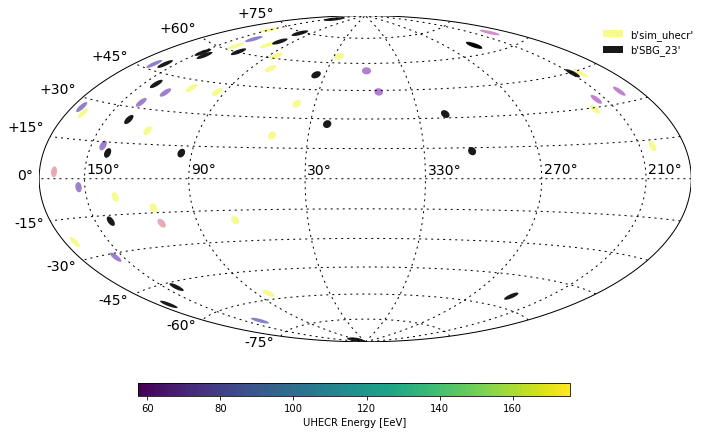

In [5]:
'''Fit using arrival direction model'''
for source_type in source_types:
    print("Current Source: {0}".format(source_type))
    # define separate files
    table_file = '../tables/tables_{0}_{1}.h5'.format(source_type, detector_type)
    sim_output_file = 'output/joint_model_simulation_{0}_{1}.h5'.format(source_type, detector_type)
    arrival_output_file = 'output/arrival_direction_fit_{0}_{1}.h5'.format(source_type, detector_type)
    # joint_output_file = 'output/joint_fit_{0}_PAO.h5'.format(source_type)

    # Define data from simulation
    data = Data()
    data.from_file(sim_output_file)

    if show_plot:
        data.show()

    # Arrival direction model
    model_name = stan_path + 'arrival_direction_model.stan'

    # Compile
    model = Model(model_filename = model_name, include_paths = stan_path)
    model.compile(reset=False)

    # Define threshold energy in EeV
    model.input(Eth = Eth)

    # What is happening 
    summary = b'Fit of the arrival direction model to the joint simulation' 
        
    # Define an Analysis object to bring together Data and Model objects
    analysis = Analysis(data, model, analysis_type = 'joint', 
                        filename = arrival_output_file, summary = summary)

    # Define location of pre-computed values used in fits 
    # (see relevant notebook for how to make these files) 
    # Each catalogue has a file of pre-computed values
    analysis.use_tables(table_file)

    # Fit the Stan model
    fit = analysis.fit_model(chains = 16, iterations = 500, seed = random_seed)

    # Save to analysis file
    analysis.save()


In [6]:
'''Fit using joint model'''
for source_type in source_types:
    print("Current Source: {0}".format(source_type))
    # define separate files
    table_file = '../tables/tables_{0}_{1}.h5'.format(source_type, detector_type)
    sim_output_file = 'output/joint_model_simulation_{0}_{1}.h5'.format(source_type, detector_type)
    # arrival_output_file = 'output/arrival_direction_fit_{0}_{1}.h5'.format(source_type, detector_type)
    joint_output_file = 'output/joint_fit_{0}_{1}.h5'.format(source_type, detector_type)

    # Define data from simulation
    data = Data()
    data.from_file(sim_output_file)

    # create Model and compile 
    model_name = stan_path + 'joint_model.stan'
    model = Model(model_filename = model_name, include_paths = stan_path)
    model.compile(reset=False)
    model.input(Eth = Eth)

    # create Analysis object
    summary = b'Fit of the joint model to the joint simulation' 
    analysis = Analysis(data, model, analysis_type = 'joint', 
                        filename = joint_output_file, summary = summary)
    analysis.use_tables(table_file)

    # Fit the Stan model
    fit = analysis.fit_model(chains = 16, iterations = 500, seed = random_seed)

    # Save to analysis file
    analysis.save()


Current Source: SBG_23
Using cached StanModel


To run all diagnostics call pystan.check_hmc_diagnostics(fit)
